In [1]:
from src.statespace import RWModel, CVModel, CAModel, StateSpace
from src.trajectory import Trajectory
from src.kalmanfilter import KalmanFilter
from src.utils import rmse

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

sns.set()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
ndat = 100
q = 9.5e-5  # Process noise intensity
r = 1.3  # Observation noise std
c_rwm = 17  # RWM Process Noise Multiplicative constant
expf_hi = 0.5
expf_lo = 0.9
init_state = np.zeros(6)

# Trajectory simulator initialization
cam = CAModel(q, r)
traj = Trajectory(cam, ndat, init_state)

In [4]:
print(traj.X[-1])

[ 1.57318345e+02  3.18127735e+02  4.12341744e+00  4.10192060e+00
  3.66536502e-02 -5.22692757e-02]


In [5]:
print(traj.model.Q)

[[4.75000000e-06 0.00000000e+00 1.18750000e-05 0.00000000e+00
  1.58333333e-05 0.00000000e+00]
 [0.00000000e+00 4.75000000e-06 0.00000000e+00 1.18750000e-05
  0.00000000e+00 1.58333333e-05]
 [1.18750000e-05 0.00000000e+00 3.16666667e-05 0.00000000e+00
  4.75000000e-05 0.00000000e+00]
 [0.00000000e+00 1.18750000e-05 0.00000000e+00 3.16666667e-05
  0.00000000e+00 4.75000000e-05]
 [1.58333333e-05 0.00000000e+00 4.75000000e-05 0.00000000e+00
  9.50000000e-05 0.00000000e+00]
 [0.00000000e+00 1.58333333e-05 0.00000000e+00 4.75000000e-05
  0.00000000e+00 9.50000000e-05]]


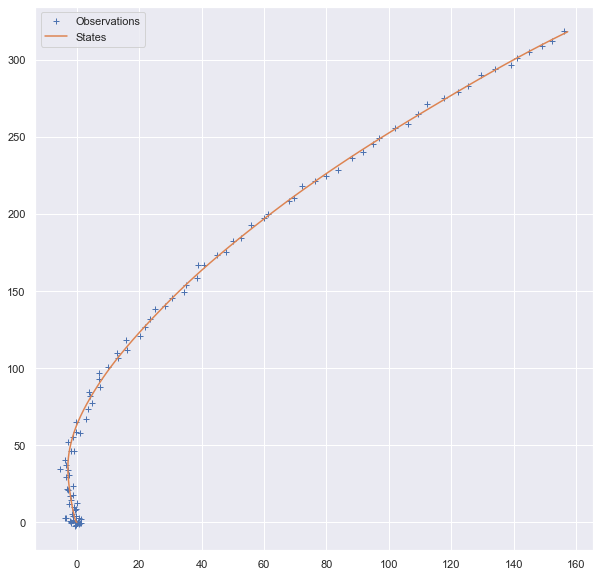

In [6]:
# Plot trajectory
plt.figure(figsize=(10, 10))
# plt.axis("equal")
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.legend()
plt.show()

In [7]:
# Model initialization
rwm = RWModel(c_rwm*q, r)
cvm = CVModel(q, r)

# Estimator initialization
kf_rwm = KalmanFilter(rwm)
kf_rwm_coop = KalmanFilter(rwm)
kf_rwm_coop2 = KalmanFilter(rwm)
kf_cvm = KalmanFilter(cvm)
kf_cam = KalmanFilter(cam)

kf_rwm_coop.add_nbhs(kf_cvm, kf_cam)
kf_rwm_coop2.add_nbhs(kf_cvm, kf_cam)
kf_cvm.add_nbhs(kf_rwm_coop, kf_cam)
kf_cam.add_nbhs(kf_rwm_coop, kf_cvm)

In [8]:
for yt in traj.observations:
    kf_rwm.predict(lambda_expf=expf_lo)
    kf_rwm_coop.predict(lambda_expf=expf_lo)
    kf_rwm_coop2.predict(lambda_expf=expf_hi)
    kf_cvm.predict()
    kf_cam.predict()
    
    kf_rwm.update(yt, log=True)
    kf_rwm_coop.update(yt)
    kf_rwm_coop2.update(yt)
    kf_cvm.update(yt)
    kf_cam.update(yt, log=True)
    
    kf_rwm_coop.get_nbh_estimates()
    kf_rwm_coop2.get_nbh_estimates()
    kf_cvm.get_nbh_estimates()
#     kf_cam.get_nbh_estimates()
    
    kf_rwm_coop.cov_intersect(log=True)
    kf_rwm_coop2.cov_intersect(log=True)
    kf_cvm.cov_intersect(log=True)
#     kf_cam.cov_intersect()
    
hist_rwm = kf_rwm.history
hist_rwm_coop = kf_rwm_coop.history
hist_rwm_coop2 = kf_rwm_coop2.history
hist_cvm = kf_cvm.history
hist_cam = kf_cam.history

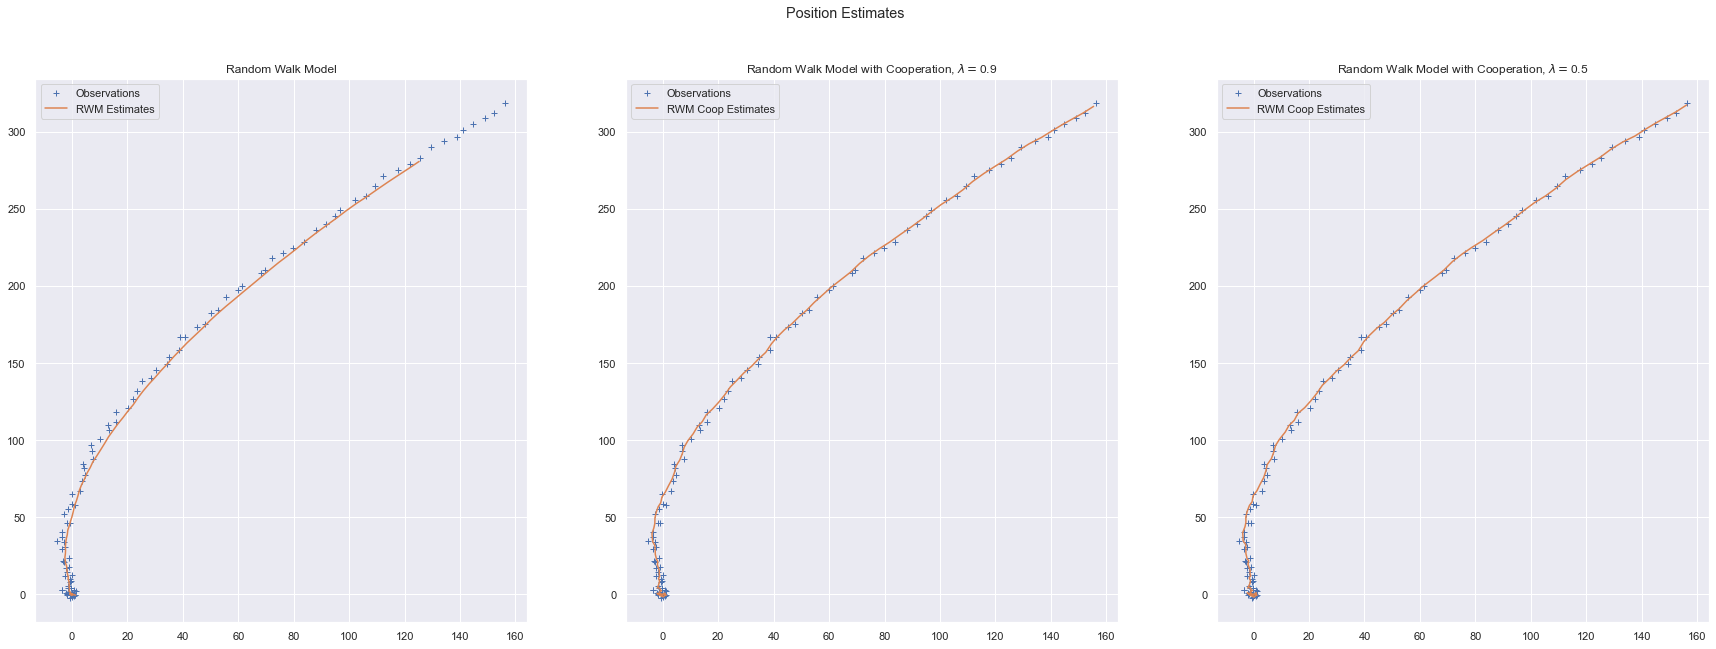

In [9]:
plt.figure(figsize=(30, 10))
plt.suptitle("Position Estimates")

plt.subplot(1, 3, 1)
plt.title("Random Walk Model")
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
# plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.plot(hist_rwm[:, 0], hist_rwm[:, 1], label="RWM Estimates")
plt.legend()

plt.subplot(1, 3, 2)
plt.title(f"Random Walk Model with Cooperation, $\lambda=${expf_lo}")
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
# plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.plot(hist_rwm_coop[:, 0], hist_rwm_coop[:, 1], label="RWM Coop Estimates")
plt.legend()

plt.subplot(1, 3, 3)
plt.title(f"Random Walk Model with Cooperation, $\lambda=${expf_hi}")
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
# plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.plot(hist_rwm_coop2[:, 0], hist_rwm_coop2[:, 1], label="RWM Coop Estimates")
plt.legend()

# plt.subplot(1, 4, 3)
# plt.title("Constant Velocity Model")
# plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
# plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
# plt.plot(hist_cam[:, 0], hist_cam[:, 1], label="CAM Estimates")
# plt.legend()

# plt.subplot(1, 4, 4)
# plt.title("Constant Acceleration Model")
# plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
# plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
# plt.plot(hist_cvm[:, 0], hist_cvm[:, 1], label="CVM Estimates")
# plt.legend()

plt.show()

In [10]:
# RMSE calculation
rmse_rwm = rmse(traj.X[:, :2], hist_rwm[:, :2], ndat)
rmse_rwm_coop = rmse(traj.X[:, :2], hist_rwm_coop[:, :2], ndat)
rmse_rwm_coop2 = rmse(traj.X[:, :2], hist_rwm_coop2[:, :2], ndat)
rmse_cvm = rmse(traj.X[:, :2], hist_cvm[:, :2], ndat)
rmse_cam = rmse(traj.X[:, :2], hist_cam[:, :2], ndat)

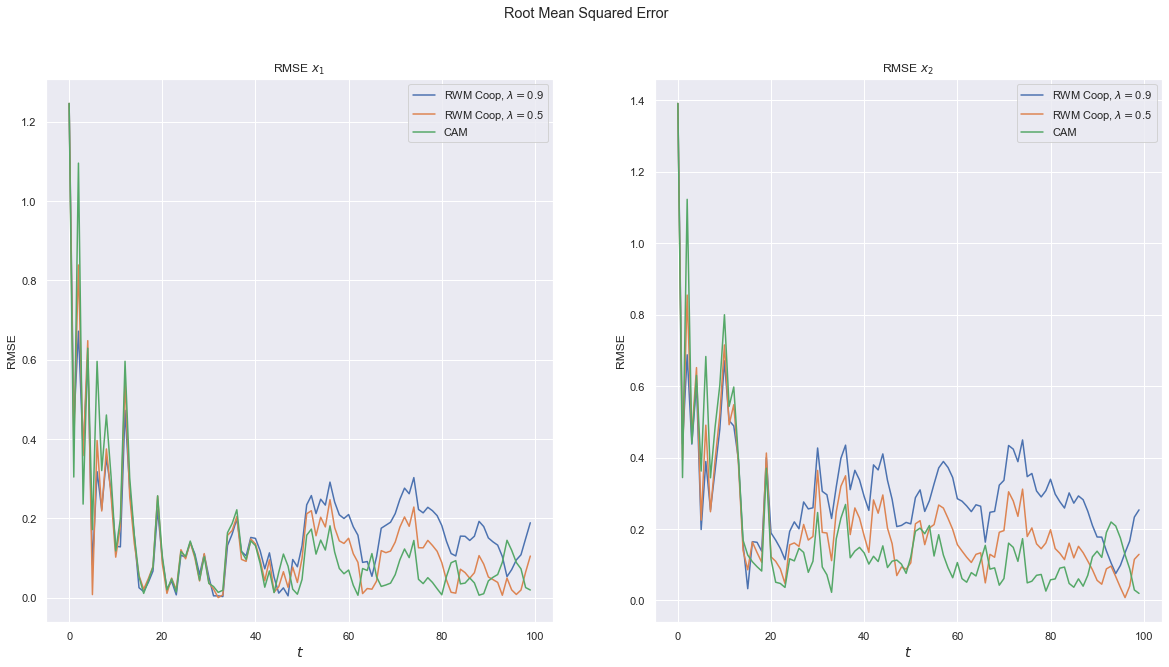

In [11]:
plt.figure(figsize=(20, 10))
plt.suptitle("Root Mean Squared Error")

plt.subplot(1, 2, 1)
plt.title("RMSE $x_1$ ")
# plt.plot(rmse_rwm[:, 0], label="RWM")
plt.plot(rmse_rwm_coop[:, 0], label=f"RWM Coop, $\lambda=${expf_lo}")
plt.plot(rmse_rwm_coop2[:, 0], label=f"RWM Coop, $\lambda=${expf_hi}")
# plt.plot(rmse_cvm[:, 0], label="CVM")
plt.plot(rmse_cam[:, 0], label="CAM")
plt.xlabel("$t$", fontsize="large")
plt.ylabel("RMSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("RMSE $x_2$ ")
# plt.plot(rmse_rwm[:, 1], label="RWM")
plt.plot(rmse_rwm_coop[:, 1], label=f"RWM Coop, $\lambda=${expf_lo}")
plt.plot(rmse_rwm_coop2[:, 1], label=f"RWM Coop, $\lambda=${expf_hi}")
# plt.plot(rmse_cvm[:, 1], label="CVM")
plt.plot(rmse_cam[:, 1], label="CAM")
plt.xlabel("$t$", fontsize="large")
plt.ylabel("RMSE")
plt.legend()

plt.show()